In [701]:
from BorderModel import IncrementalModel, daily_average_features
from BorderQuery import select_features_simple, select_mungedata_simple
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
import pprint

In [418]:
df_train = select_mungedata_simple(2, 1, '2011-1-1', '2015-1-1')

In [419]:
X_test = select_features_simple('2015-1-1', '2015-12-1')

In [420]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=16, bootstrap=True, oob_score=True)
grid = GridSearchCV(model, {})

In [424]:
from BorderModel import IncrementalModel
im = IncrementalModel(df_train, grid)

In [454]:
from BorderModel import IncrementalModel
yhat = im.predict(X_test)

2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
2015-01-12
2015-01-13
2015-01-14
2015-01-15
2015-01-16
2015-01-17
2015-01-18
2015-01-19
2015-01-20
2015-01-21
2015-01-22
2015-01-23
2015-01-24
2015-01-25
2015-01-26
2015-01-27
2015-01-28
2015-01-29
2015-01-30
2015-01-31
2015-02-01
2015-02-02
2015-02-03
2015-02-04
2015-02-05
2015-02-06
2015-02-07
2015-02-08
2015-02-09
2015-02-10
2015-02-11
2015-02-12
2015-02-13
2015-02-14
2015-02-15
2015-02-16
2015-02-17
2015-02-18
2015-02-19
2015-02-20
2015-02-21
2015-02-22
2015-02-23
2015-02-24
2015-02-25
2015-02-26
2015-02-27
2015-02-28
2015-03-01
2015-03-02
2015-03-03
2015-03-04
2015-03-05
2015-03-06
2015-03-07
2015-03-08
2015-03-09
2015-03-10
2015-03-11
2015-03-12
2015-03-13
2015-03-14
2015-03-15
2015-03-16
2015-03-17
2015-03-18
2015-03-19
2015-03-20
2015-03-21
2015-03-22
2015-03-23
2015-03-24
2015-03-25
2015-03-26
2015-03-27
2015-03-28
2015-03-29
2015-03-30
2015-03-31
2015-04-01

## Compare against actuals in 2015

In [490]:
actuals = select_mungedata_simple(2, 1, '2015-1-1', '2015-12-1')
actuals = actuals.set_index('date')
actuals = actuals[(actuals.index.minute == 0) | (actuals.index.minute==30)].waittime

In [547]:
from BorderQuery import select_predictions
baseline = select_predictions(2, 'b2014', 1, '2015-1-1', '2015-12-1')

baseline = baseline[(baseline.index.minute == 0) | (baseline.index.minute==30)]

baseline1 = baseline.loc[actuals.index]

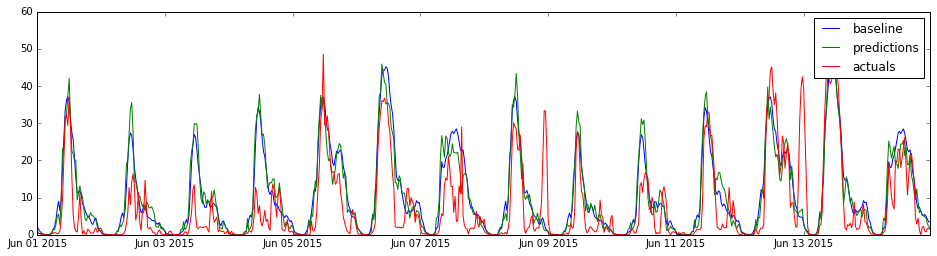

In [548]:
start = dt.date(2015, 6, 1)
end = dt.date(2015, 6, 15)

plt.figure(figsize=(16,4))
plt.plot(baseline[(baseline.index.date>=start) & (baseline.index.date<end)], label='baseline')
plt.plot(yhat[(yhat.index.date>=start) & (yhat.index.date<end)], label='predictions')
plt.plot(actuals[(actuals.index.date>=start) & (actuals.index.date<end)], label='actuals')
# plt.xlim([0,1000])
plt.legend();

In [518]:
yhat1 = yhat[actuals.index]

In [500]:
yhat[actuals.index.values].head()

date
2015-01-01 00:00:00    0.762914
2015-01-01 00:30:00    1.945724
2015-01-01 01:00:00    2.264253
2015-01-01 01:30:00    1.343402
2015-01-01 02:00:00    1.210180
dtype: float64

In [550]:
print r2_score(actuals, baseline1)
print r2_score(actuals, yhat1)

0.147222831424
-0.0328163534288


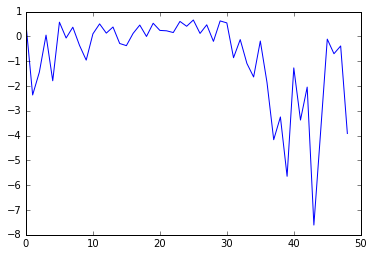

In [524]:
r2_byweek = []
for week in range(1, 50):
    r2_byweek.append(r2_score(actuals[actuals.index.week==week], yhat1[yhat1.index.week==week]))
    
plt.plot(r2_byweek);

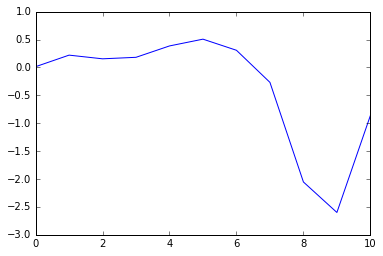

In [525]:
r2_bymonth = []
for month in range(1, 12):
    r2_bymonth.append(r2_score(actuals[actuals.index.month==month], yhat1[yhat1.index.month==month]))
    
plt.plot(r2_bymonth);

In [537]:
print sorted(zip(im.X.columns, grid.best_estimator_.feature_importances_), key=lambda x: x[1])[::-1]

[('minofday', 0.56826360203785142), ('dayofweek', 0.1000209373716259), ('avg_roll_7', 0.065863387802658671), ('avg_roll_14', 0.047653051312855098), ('week', 0.041514107058660439), ('avg_roll_21', 0.041309976681715592), ('avg_roll_366', 0.037849198733552532), ('avg_roll_28', 0.036007612710165046), ('month', 0.03557313836653616), ('year', 0.025944987924379138)]


### R2 is poor with only date features and rolling_means
## Add lag averages

In [614]:
from BorderModel import IncrementalModel
model2 = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
grid2 = GridSearchCV(model2, {})
im2 = IncrementalModel(df_train, grid2)

In [615]:
from BorderModel import IncrementalModel
yhat2 = im2.predict(X_test)

yhat2 = yhat2[actuals.index]

In [616]:
print r2_score(actuals, baseline1)
print r2_score(actuals, yhat2)

0.147222831424
-0.0892025236631


In [617]:
print sorted(zip(im2.X.columns, grid2.best_estimator_.feature_importances_), key=lambda x: x[1])[::-1]

[('minofday', 0.57139640968429561), ('avg_lag_1', 0.076705382241711653), ('dayofweek', 0.067535568457219211), ('avg_lag_7', 0.027545721797941885), ('avg_lag_6', 0.022398533155319218), ('week', 0.022335348011309139), ('avg_roll_7', 0.022050681172641386), ('avg_lag_2', 0.021686621801873602), ('avg_lag_5', 0.020271894366890118), ('avg_lag_4', 0.020249958201817925), ('avg_lag_3', 0.020234198157227226), ('avg_roll_366', 0.019999760717677666), ('month', 0.019851489876190658), ('avg_roll_14', 0.019159589759552894), ('avg_roll_21', 0.016230496013434854), ('year', 0.016182826775168573), ('avg_roll_28', 0.016165519809728583)]


In [618]:
im2.X.tail()

,year,month,week,dayofweek,minofday,avg_roll_7,avg_roll_14,avg_roll_21,avg_roll_28,avg_roll_366,avg_lag_1,avg_lag_2,avg_lag_3,avg_lag_4,avg_lag_5,avg_lag_6,avg_lag_7
date,,,,,,,,,,,,,,,,,
2014-12-31 21:30:00,2014,12,1,2,1290,15.799662,12.812575,11.166439,9.597144,10.375526,20.736286,22.156865,17.620147,21.439253,15.316553,7.748564,5.579969
2014-12-31 22:00:00,2014,12,1,2,1320,15.799662,12.812575,11.166439,9.597144,10.375526,20.736286,22.156865,17.620147,21.439253,15.316553,7.748564,5.579969
2014-12-31 22:30:00,2014,12,1,2,1350,15.799662,12.812575,11.166439,9.597144,10.375526,20.736286,22.156865,17.620147,21.439253,15.316553,7.748564,5.579969
2014-12-31 23:00:00,2014,12,1,2,1380,15.799662,12.812575,11.166439,9.597144,10.375526,20.736286,22.156865,17.620147,21.439253,15.316553,7.748564,5.579969
2014-12-31 23:30:00,2014,12,1,2,1410,15.799662,12.812575,11.166439,9.597144,10.375526,20.736286,22.156865,17.620147,21.439253,15.316553,7.748564,5.579969


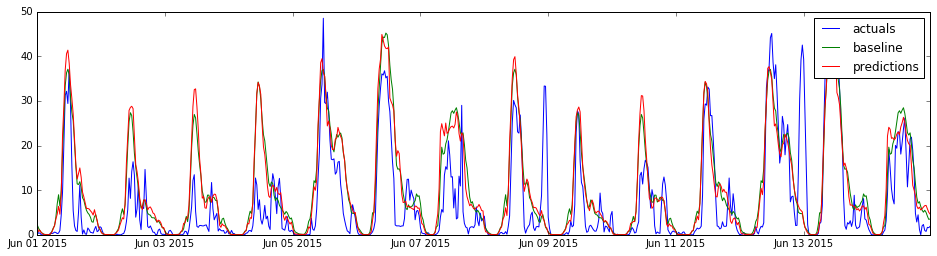

In [619]:
start = dt.date(2015, 6, 1)
end = dt.date(2015, 6, 15)

plt.figure(figsize=(16,4))
plt.plot(actuals[(actuals.index.date>=start) & (actuals.index.date<end)], label='actuals')
plt.plot(baseline[(baseline.index.date>=start) & (baseline.index.date<end)], label='baseline')
plt.plot(yhat2[(yhat2.index.date>=start) & (yhat2.index.date<end)], label='predictions')
# plt.xlim([0,1000])
plt.legend();

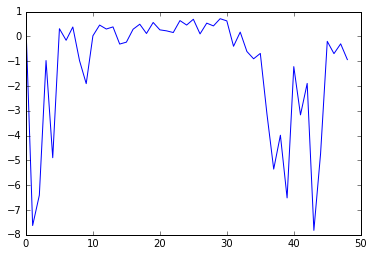

In [620]:
r2_byweek = []
for week in range(1, 50):
    r2_byweek.append(r2_score(actuals[actuals.index.week==week], yhat2[yhat2.index.week==week]))
    
plt.plot(r2_byweek);

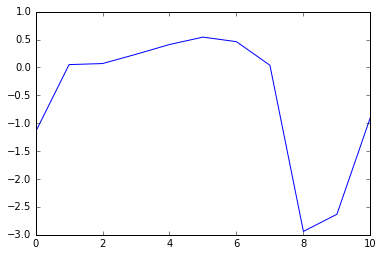

In [697]:
r2_bymonth = []
for month in range(1, 12):
    r2_bymonth.append(r2_score(actuals[actuals.index.month==month], yhat2[yhat2.index.month==month]))
    
plt.plot(r2_bymonth);

### Lag averages does not improve model.  Note that avg_lag_1 is 2nd strongest feature
## Try with all features

In [624]:
from BorderQuery import select_mungedata, select_features
df_train = select_mungedata(2, 1, '2011-1-1', '2015-1-1')

In [651]:
X_test = select_features('2015-1-1', '2016-1-1')

In [666]:
from BorderModel import IncrementalModel
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
grid = GridSearchCV(model, {})
im3 = IncrementalModel(df_train, grid, categoricals=['event'])

In [667]:
yhat3 = im3.predict(X_test)

In [668]:
yhat3 = yhat3[actuals.index]

In [669]:
print r2_score(actuals, baseline1)
print r2_score(actuals, yhat3)

0.147222831424
-0.00890126901626


In [670]:
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(sorted(zip(im3.X.columns, grid.best_estimator_.feature_importances_), key=lambda x: x[1])[::-1])

[   ('minofday', 0.56996189177492995),
    ('dayofweek', 0.059602991904057351),
    ('avg_lag_1', 0.053698825343636979),
    ('avg_lag_7', 0.013745147160569149),
    ('avg_roll_7', 0.01104345345722439),
    ('avg_lag_6', 0.0083508712978132491),
    ('avg_lag_2', 0.0078708411051088469),
    ('avg_roll_366', 0.0076900947544932645),
    ('avg_roll_14', 0.0074757948661214315),
    ('avg_lag_5', 0.0068410688628135442),
    ('event_goodfriday', 0.0066419954755253261),
    ('year', 0.0065709909603534752),
    ('week', 0.00639488148778216),
    ('avg_lag_4', 0.0063374095780029263),
    ('month', 0.0063279920859263998),
    ('avg_roll_21', 0.0060533051918197538),
    ('avg_lag_3', 0.0058955297048397795),
    ('event_lag2_xmas', 0.0054342952843050608),
    ('temp_min_m2', 0.0054245244593379696),
    ('avg_roll_28', 0.005269201334296386),
    ('wind_max', 0.0050718569499066685),
    ('temp_min_m1', 0.0049745110448661005),
    ('precip_p2', 0.0049265925691534731),
    ('temp_mean_m2', 0.0047523894

### Other features do not improve model.  Average features override holiday features.
* Is the problem due to how anomalous 2015 Peace Arch data is?
* Can 2014 be better predicted?
* How does model perform if predictions are made just 1 week at a time?

## Test 2014

In [672]:
from BorderQuery import select_mungedata, select_features
df_train = select_mungedata(2, 1, '2011-1-1', '2014-1-1')
X_test = select_features('2014-1-1', '2015-1-1')
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
grid = GridSearchCV(model, {})
im4 = IncrementalModel(df_train, grid, categoricals=['event'])

In [ ]:
yhat4 = im4.predict(X_test)

In [676]:
yhat4.head()

date
2014-01-01 00:00:00    0.375251
2014-01-01 00:30:00    0.128979
2014-01-01 01:00:00    0.176562
2014-01-01 01:30:00    0.172873
2014-01-01 02:00:00    0.072466
dtype: float64

In [677]:
actuals4 = select_mungedata_simple(2, 1, '2014-1-1', '2014-12-1')
actuals4 = actuals4.set_index('date')
actuals4 = actuals4[(actuals4.index.minute == 0) | (actuals4.index.minute==30)].waittime

In [682]:
baseline4 = select_predictions(2, 'b2014', 1, '2014-1-1', '2014-12-1')
baseline4 = baseline4[(baseline4.index.minute == 0) | (baseline4.index.minute==30)]
baseline4_ = baseline4.loc[actuals.index]

AttributeError: 'Index' object has no attribute 'minute'

In [683]:
yhat4_ = yhat4[actuals4.index]
# print r2_score(actuals4, baseline4_)
print r2_score(actuals4, yhat4_)

0.56317120945


### Not as poor as 2015 prediction, but no better than baseline (.563 vs .569) whereas model without averages did better than baseline (.619)

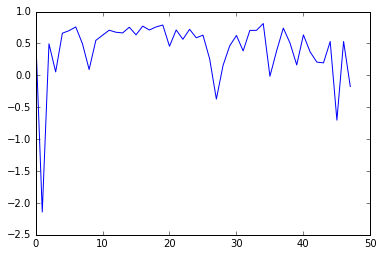

In [695]:
r2_byweek = []
for week in range(1, 49):
    r2_byweek.append(r2_score(actuals4[actuals4.index.week==week], yhat4_[yhat4_.index.week==week]))
    
plt.plot(r2_byweek);

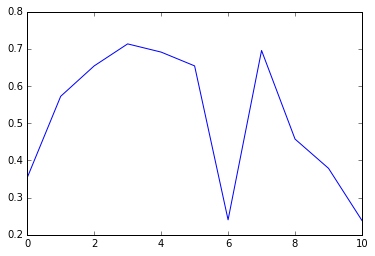

In [696]:
r2_bymonth = []
for month in range(1, 12):
    r2_bymonth.append(r2_score(actuals4[actuals4.index.month==month], yhat4_[yhat4_.index.month==month]))
    
plt.plot(r2_bymonth);

In [698]:
pp.pprint(sorted(zip(im4.X.columns, grid.best_estimator_.feature_importances_), key=lambda x: x[1])[::-1])

[   ('minofday', 0.5808019136282313),
    ('avg_lag_1', 0.055933033161222084),
    ('dayofweek', 0.052380534541095584),
    ('avg_lag_7', 0.013060951587348402),
    ('avg_roll_7', 0.009236909416893849),
    ('avg_roll_14', 0.0078450701822688103),
    ('avg_lag_6', 0.0073261043566726957),
    ('week', 0.0068953273745321515),
    ('year', 0.0067748357411662836),
    ('avg_lag_2', 0.0063749277668712695),
    ('month', 0.0062084375493074795),
    ('event_lag2_xmas', 0.0061746531821116656),
    ('avg_lag_5', 0.0060177632308914307),
    ('avg_lag_4', 0.0059035367364327915),
    ('wind_max', 0.0053425838161085711),
    ('avg_roll_366', 0.0053265890870216439),
    ('temp_min', 0.0053077650213122539),
    ('avg_lag_3', 0.0052798463786897171),
    ('avg_roll_28', 0.0052433107337012327),
    ('avg_roll_21', 0.0052179324436162113),
    ('temp_min_m2', 0.0049310932244178074),
    ('temp_mean_m2', 0.0048987560012091636),
    ('event_goodfriday', 0.0046743340484948709),
    ('precip_m2', 0.0046621684

### Interestingly, even though avg_lag_1 is a strong feature, R2 for nearest weeks is worse than several weeks out

## Test 2013

In [841]:
from BorderQuery import select_mungedata, select_features
from BorderModel import IncrementalModel

df_train = select_mungedata(2, 1, '2011-1-1', '2013-1-1')
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
grid = GridSearchCV(model, {})
im2013 = IncrementalModel(df_train, grid, categoricals=['event'])

In [842]:
from BorderModel import IncrementalModel
im2013.percent_nonnull = .3
X_test = select_features('2013-1-1', '2014-1-1')
yhat2013 = im2013.predict(X_test)

In [843]:
actuals2013 = select_mungedata_simple(2, 1, '2013-1-1', '2014-1-1')

In [850]:
from BorderModel import IncrementalModel
im2013.score(actuals2013.waittime)

 Model R2:  0.630303351513
Baseline R2:  0.613087822083
Ensemble R2:  0.642220062011


In [851]:
pp.pprint(sorted(zip(im4.X.columns, grid.best_estimator_.feature_importances_), key=lambda x: x[1])[::-1])

[   ('minofday', 0.59857329065093956),
    ('dayofweek', 0.049407749072833025),
    ('avg_lag_1', 0.044109234551492023),
    ('avg_lag_7', 0.011961387748427582),
    ('event_lag2_xmas', 0.010718157668369137),
    ('week', 0.0084406449112549783),
    ('avg_lag_2', 0.0074394858024342545),
    ('month', 0.0070881963575105929),
    ('avg_roll_366', 0.0066624536171079928),
    ('avg_lag_6', 0.0066005774221796079),
    ('wind_max', 0.0063830962800992081),
    ('avg_lag_4', 0.0061124778994445924),
    ('temp_min_p3', 0.0059442992815042818),
    ('avg_roll_7', 0.0058019396507694486),
    ('avg_lag_3', 0.0057361105372747316),
    ('event_goodfriday', 0.0056676185299502141),
    ('avg_lag_5', 0.0053797129052024391),
    ('temp_min_m1', 0.0053272006398108127),
    ('temp_mean_m2', 0.0053192760858837484),
    ('precip_p1', 0.0052455635556747102),
    ('temp_min_p1', 0.0052428432219235365),
    ('temp_min', 0.0051160984397144683),
    ('temp_min_m2', 0.0049699204415789401),
    ('temp_max_m2', 0.00

In [854]:
daily = im2013.y.resample('D', how='mean')

In [859]:
print daily.tail()
print daily.shift(1).tail()

date
2012-12-27    20.336380
2012-12-28    17.264235
2012-12-29    19.106600
2012-12-30    16.834873
2012-12-31     7.428324
Freq: D, Name: waittime, dtype: float64
date
2012-12-27    12.722063
2012-12-28    20.336380
2012-12-29    17.264235
2012-12-30    19.106600
2012-12-31    16.834873
Freq: D, Name: waittime, dtype: float64


## Rolling and lag features appear to be overfitting.  Try a feature which captures delta averages for purpose of capturing trends.

In [876]:
from BorderModel import IncrementalModel

df_train = select_mungedata(2, 1, '2011-1-1', '2015-1-1')
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=16, bootstrap=True, oob_score=True)
grid = GridSearchCV(model, {})
im2015 = IncrementalModel(df_train, grid, categoricals=['event'], rolling=False, lag=False)

In [875]:
from BorderModel import IncrementalModel
# im2015.percent_nonnull=.6
X_test = select_features('2015-1-1', '2016-1-1')
yhat2015 = im2015.predict(X_test)

ValueError: Last day of training data must be day before first day of test data.